In [2]:
DIR = 'F:/'
TRAIN_DF_PATH = DIR + "train.csv"
TEST_DF_PATH = DIR + 'test.csv'
TRAIN_IMG_PATH = DIR + "train_images/"
TEST_IMG_PATH = DIR + 'test_images/'

In [3]:
BASE_DIR = 'F:/'
TRAIN_IMAGE_DIR = 'F:/train_images'
TEST_IMAGE_DIR = 'F:/test_images'
train_csv = 'F:/train.csv'
test_csv = 'F:/test.csv'
IMAGE_SIZE = 224
BATCH_SIZE = 10

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [5]:
train_df = pd.read_csv(train_csv)
train_df.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [6]:
test_df = pd.read_csv(test_csv)
test_df.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [7]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')
train_df['id_code'] = train_df['id_code'].astype(str)+'.png'
test_df['id_code'] = test_df['id_code'].astype(str)+'.png'

In [8]:
def crop_image_from_gray(img, tol=7):
   
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
   
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
       
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [9]:
def preprocess_image(image, sigmaX=10):
   
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    validation_split=0.2,
    preprocessing_function = preprocess_image
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'training',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 2930 validated image filenames belonging to 5 classes.


In [14]:
val_gen = datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    subset = 'validation',
    directory = TRAIN_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 732 validated image filenames belonging to 5 classes.


In [15]:
test_gen = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = None,
    x_col = 'id_code',
    target_size = (IMAGE_SIZE,IMAGE_SIZE),
    directory = TEST_IMAGE_DIR,
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 1928 validated image filenames.


In [16]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
encoded_diagnosis = onehot_encoder.fit_transform(train_df[['diagnosis']])
print(encoded_diagnosis)

[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras import layers
from keras.layers import Dropout, GaussianNoise, GaussianDropout,GlobalAveragePooling2D
from keras.layers import Flatten, BatchNormalization
from keras.layers.convolutional import Conv2D, SeparableConv2D
from keras.constraints import maxnorm
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras import regularizers, optimizers
from keras.models import load_model

In [18]:
from keras.applications.inception_v3 import InceptionV3
inet = InceptionV3(include_top = False, weights='imagenet', input_shape=(224,224,3))
model = Sequential()
model.add(inet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(lr=0.0001, amsgrad=True), metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10245     
Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
_________________________________________________________________


In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop= EarlyStopping(monitor='val_loss', mode ='min', verbose = 1, patience = 20)
model_checkpoint = ModelCheckpoint('Incppmodel.h5', monitor='val_loss', save_best_only = True, mode ='min', verbose = 1)

In [25]:
model.fit_generator(generator=train_gen,              
                                    steps_per_epoch=len(train_gen)//BATCH_SIZE,
                                    validation_data=val_gen,                    
                                    validation_steps=len(val_gen)//BATCH_SIZE,
                                    epochs=50,
                                    callbacks = [early_stop],
                                    verbose=1)

model.save('Inceptionpp.h5')

Epoch 1/50
29/29 [==============================] - 323s 11s/step - loss: 0.4124 - accuracy: 0.8393 - val_loss: 0.2316 - val_accuracy: 0.8371
Epoch 2/50
29/29 [==============================] - 245s 8s/step - loss: 0.3278 - accuracy: 0.8669 - val_loss: 0.3227 - val_accuracy: 0.8771
Epoch 3/50
29/29 [==============================] - 248s 9s/step - loss: 0.2711 - accuracy: 0.8917 - val_loss: 0.3812 - val_accuracy: 0.8771
Epoch 4/50
29/29 [==============================] - 246s 8s/step - loss: 0.2632 - accuracy: 0.8952 - val_loss: 0.2748 - val_accuracy: 0.8971
Epoch 5/50
29/29 [==============================] - 250s 9s/step - loss: 0.2512 - accuracy: 0.8945 - val_loss: 0.3675 - val_accuracy: 0.9171
Epoch 6/50
29/29 [==============================] - 251s 9s/step - loss: 0.2592 - accuracy: 0.8883 - val_loss: 0.1375 - val_accuracy: 0.8914
Epoch 7/50
29/29 [==============================] - 251s 9s/step - loss: 0.2698 - accuracy: 0.8945 - val_loss: 0.2785 - val_accuracy: 0.9086
Epoch 8/50
2

In [26]:
y_test = model.predict_generator(
    test_gen,
    steps=len(test_gen),
    verbose=1
)

193/193 [==============================] - 432s 2s/step


In [27]:
loss, accuracy = model.evaluate_generator(val_gen, steps=3, verbose=1)
print("Loss of the model: ",loss)
print("Accuracy of the model: ",accuracy)


3/3 [==============================] - 13s 4s/step
Loss of the model:  0.09011518955230713
Accuracy of the model:  0.9466666579246521


In [28]:
accuracy, val_accuracy = model.history.history['accuracy'], model.history.history['val_accuracy']
loss, val_loss = model.history.history['loss'], model.history.history['val_loss']
epochs = range(len(accuracy))
import matplotlib.pyplot as pl

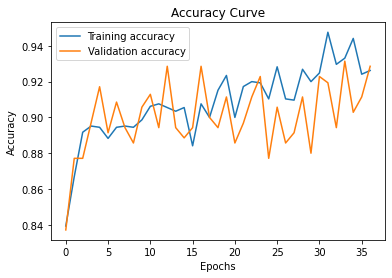

In [29]:
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

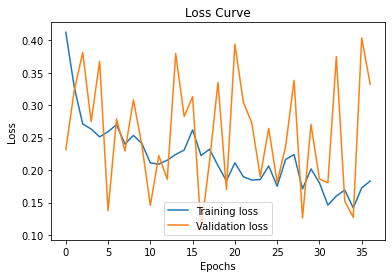

In [30]:
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
